#### IMPORTS

In [283]:
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from random import randint
from collections import defaultdict
from math import exp, log
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as mtp


#### PARAMS

In [284]:
FILES = ["chips", "geyser"]
INF = float('inf')
EPS = 1e-30

#### FOREST

In [285]:
class ForestClassifier:
    def __init__(self, forest_size=10, max_depth=INF, min_size=5):
        self.forest_size = forest_size
        self.max_depth = max_depth
        self.min_size = min_size

    def bootstrap(self, X):
        n = len(X)
        data = []
        for i in range(self.forest_size):
            current = []
            for j in range(n):
                current.append(X[randint(0, n - 1)])
            data.append(current)
        return np.array(data)

    def fit(self, data):
        return [self.build_tree(train) for train in self.bootstrap(data)]

    def build_tree(self, train):
        root = get_split(train)
        self.split(root, 1)
        return root

    def split(self, node, depth):
        left, right = node['groups']
        del (node['groups'])
        if left.size == 0 or right.size == 0:
            node['left'] = node['right'] = most_common(np.concatenate((left, right)))
            return
        if depth >= self.max_depth:
            node['left'], node['right'] = most_common(left), most_common(right)
            return
        if len(left) <= self.min_size:
            node['left'] = most_common(left)
        else:
            node['left'] = get_split(left)
            self.split(node['left'], depth + 1)

        if len(right) <= self.min_size:
            node['right'] = most_common(right)
        else:
            node['right'] = get_split(right)
            self.split(node['right'], depth + 1)

    def predict(self, node, row):
        side = 'left' if row[node['index']] < node['value'] else 'right'
        return self.predict(node[side], row) if isinstance(node[side], dict) else node[side]

    def test(self, forest, test, draw=False):
        correctly_predicted = 0
        predictions = []
        for row in test:
            predicted_count = defaultdict(lambda: 0)
            for tree in forest:
                predicted_count[self.predict(tree, row)] += 1
            cls = max(predicted_count, key=predicted_count.get)
            correctly_predicted += 1 if cls == row[-2] else 0
            predictions.append(cls)
        score, predicted = correctly_predicted / len(test), np.array(predictions)
        if draw:
            self.draw(forest, test)
        return score, predicted

    def draw(self, forest, X):
        y = X[:, -2]
        bg_x = np.array([(*x, None) for x in it.product(np.linspace(min(X[:, 0]), max(X[:, 0]), 75),
                                                        np.linspace(min(X[:, 1]), max(X[:, 1]), 75))])
        _, bg_y = self.test(forest, bg_x)
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='+', color='green')
        plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], marker='_', color='red')
        plt.scatter(bg_x[bg_y == 1][:, 0], bg_x[bg_y == 1][:, 1], marker='.', color='green', alpha=0.2)
        plt.scatter(bg_x[bg_y == -1][:, 0], bg_x[bg_y == -1][:, 1], marker='.', color='red', alpha=0.2)
        plt.show()

#### AdaBoost

In [286]:
class AdaBoost:
    def __init__(self):
        self.model = ForestClassifier(max_depth=3)

    def fit(self, data, t):
        def calc_error(tree, tt):
            return np.sum(
                [D[index][tt] * (self.model.predict(tree, data[index]) != data[index][-2]) for index in range(size)])

        def get_min_arg(_forest, tt):
            best_arg = _forest[0]
            best_error = calc_error(best_arg, 0)
            for tree in _forest:
                e = calc_error(tree, tt)
                if e < best_error:
                    best_arg = tree
                    best_error = e
            return best_arg

        h, a = [], []
        forest = self.model.fit(data)
        size = len(data)
        D = [[1 / size] for _ in range(size)]

        for ti in range(t):
            h.append(get_min_arg(forest, ti))
            error = calc_error(h[ti], ti)
            if error < EPS:
                return h, a
            a.append(0.5 * log((1 - error) / error))
            for i in range(size):
                D[i].append(D[i][ti] * exp(-a[ti] * data[i][-2] * self.model.predict(h[ti], data[i])))
            z = np.sum([D[i][ti + 1] for i in range(size)])
            for i in range(size):
                D[i][ti + 1] /= z
        return h, a

    def predict(self, h, a, row):
        return np.sign(np.sum([a[t] * self.model.predict(h[t], row) for t in range(len(a))]))

    def test(self, test, h, a):
        return accuracy_score(test[:, -2], [self.predict(h, a, row) for row in test])


#### HELPERS

In [287]:
def most_common(group):
    sums = defaultdict(lambda: 0)
    count = defaultdict(lambda: 0)
    for row in group:
        count[row[-2]] += 1
        sums[row[-2]] += row[-1]
    return max(sums, key=lambda el: sums[el] / count[el])


def gini_index(groups):
    n_instances = sum([sum(group[:, -1]) for group in groups])
    gini = 0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        score = 0
        s = np.sum(group[:, -1])
        for c in {0, 1}:
            p = np.sum([row[-1] if row[-2] == c else 0 for row in group]) / s
            score += p * p
        gini += (1.0 - score) * (s / n_instances)
    return gini


def get_split(data):
    b_index, b_value, b_score, b_groups = INF, INF, INF, None
    for index in range(len(data[0]) - 2):
        for row in data:
            groups = data[data[:, index] < row[index]], data[data[:, index] >= row[index]]
            gini = gini_index(groups)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index': b_index, 'value': b_value, 'groups': b_groups}


def split_data_on_train_and_test(data):
    return data[:2 * len(data) // 3], data[2 * len(data) // 3:]


def get_data_with_weights(data, weights=None):
    ww = np.ones((len(data), 1)) if weights is None else list(map(lambda w: [w], weights))
    return np.append(data, ww, axis=1)

#### MAIN

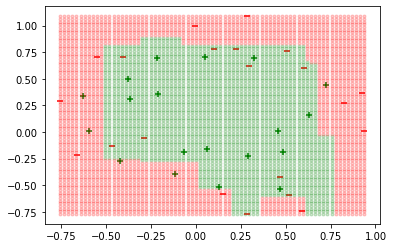

Forest score for chips: 0.6000000000%
Ada Boost score for chips: 0.6250000000%, t = 1
Ada Boost score for chips: 0.6250000000%, t = 2
Ada Boost score for chips: 0.6000000000%, t = 3
Ada Boost score for chips: 0.6000000000%, t = 5
Ada Boost score for chips: 0.5750000000%, t = 8
Ada Boost score for chips: 0.5750000000%, t = 13
Ada Boost score for chips: 0.5500000000%, t = 21
Ada Boost score for chips: 0.6000000000%, t = 34
Ada Boost score for chips: 0.6750000000%, t = 55


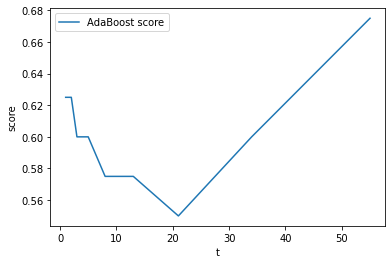

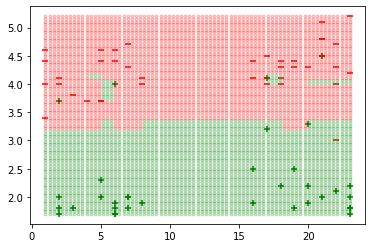

Forest score for geyser: 0.8783783784%
Ada Boost score for geyser: 0.9054054054%, t = 1
Ada Boost score for geyser: 0.9054054054%, t = 2
Ada Boost score for geyser: 0.8513513514%, t = 3
Ada Boost score for geyser: 0.9054054054%, t = 5
Ada Boost score for geyser: 0.9189189189%, t = 8
Ada Boost score for geyser: 0.8648648649%, t = 13
Ada Boost score for geyser: 0.8378378378%, t = 21
Ada Boost score for geyser: 0.9054054054%, t = 34
Ada Boost score for geyser: 0.9054054054%, t = 55


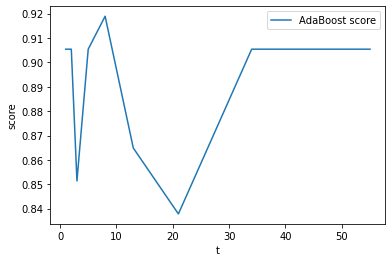

In [288]:
def main():
    model_forest = ForestClassifier()
    model_adaboost = AdaBoost()
    for file in FILES:
        dataset = pd.read_csv('data/%s.csv' % file).sample(frac=1)
        dataset['class'] = dataset['class'].apply(lambda y: 1 if y == 'P' else -1)
        data = get_data_with_weights(dataset.values)
        data_train, data_test = split_data_on_train_and_test(data)
        forest = model_forest.fit(data_train)
        score, _ = model_forest.test(forest, data_test, draw=True)
        print('Forest score for %s: %.10f%%' % (file, score))

        ts, scores = [1, 2, 3, 5, 8, 13, 21, 34, 55], []
        for t in ts:
            h, a = model_adaboost.fit(data_train, t)
            scores.append(model_adaboost.test(data_test, h, a))
            print('Ada Boost score for %s: %.10f%%, t = %d' % (file, scores[-1], t))
        mtp.plot(ts, scores, label="AdaBoost score")
        mtp.xlabel("t")
        mtp.ylabel("score")
        mtp.legend()
        mtp.show()


if __name__ == '__main__':
    main()